<a href="https://colab.research.google.com/github/AhmedAllien/Image-processing-Tumor-Segmentation-/blob/master/project_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
!pip install SimpleITK pydicom scikit-learn scikit-fuzzy
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 
from PIL import ImageOps
import SimpleITK as sitk
import cv2
from skimage import color,filters
import skimage
from past.builtins import xrange
from skimage import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
import skfuzzy as fuzz
import argparse
from time import time
import tensorflow as tf
# Import Packs
import numpy as np #Version: v1.14.3
import pydicom as dc # v1.0.2
import glob
import matplotlib.pyplot as plt #v2.1.2
from matplotlib import rcParams

import seaborn as sns # Seaborn: v0.10.0

sns.set(style="whitegrid", color_codes=True)
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 10,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [8.5, 8.5]
}
rcParams.update(params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [0]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    print(slices[0].pixel_array)
    return slices



In [0]:

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 1
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)
    

In [5]:
data_path = "/content/drive/My Drive/3Dircadb1.1/PATIENT_DICOM"
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)


[[-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 ...
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]
 [-1024 -1024 -1024 ... -1024 -1024 -1024]]


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
output_path = working_path = "/content/drive/My Drive/3Dircadb1.1/PATIENT_DICOMOUTPUT"
np.save(output_path + "fullimages_%d.npy" % (0), imgs)

In [0]:
# file_used=output_path+"fullimages_%d.npy" % (0)
# imgs_to_process = np.load(file_used).astype(np.float64) 

# plt.hist(imgs_to_process.flatten(), bins=50, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")

# plt.show()

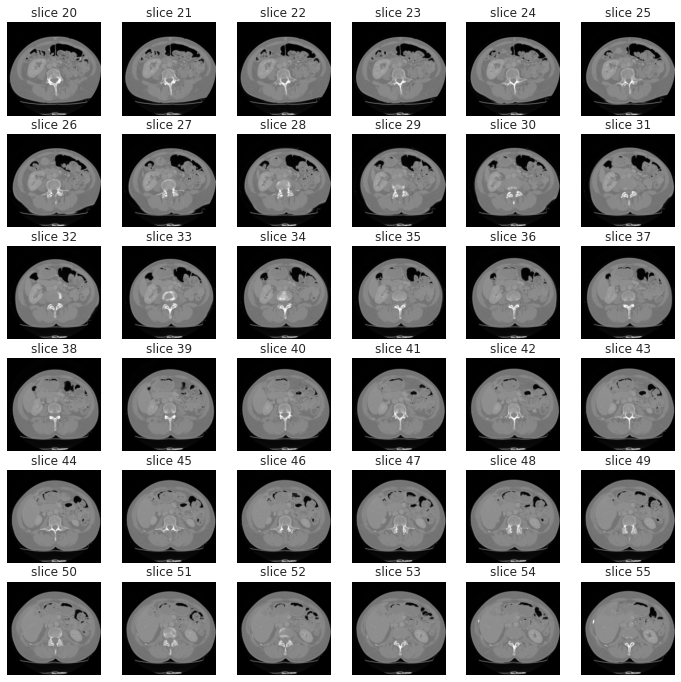

In [9]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))

def sample_stack(stack, rows=6, cols=6, start_with=20, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

sample_stack(imgs_to_process)

In [0]:
id = 0
imgs_to_process = np.load(output_path+'fullimages_{}.npy'.format(id))
# def resample(image, scan, new_spacing=[1,1,1]):
#     # Determine current pixel spacing
#     spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
#     spacing = np.array(list(spacing))

#     resize_factor = spacing / new_spacing
#     new_real_shape = image.shape * resize_factor
#     new_shape = np.round(new_real_shape)
#     real_resize_factor = new_shape / image.shape
#     new_spacing = spacing / real_resize_factor
    
#     image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
#     return image, new_spacing

# print ("Shape before resampling\t", imgs_to_process.shape)
# imgs_after_resamp, spacing = resample(imgs_to_process, patient, [1,1,1])
# print ("Shape after resampling\t", imgs_after_resamp.shape)

In [0]:
# croped_image  = imgs_to_process[0]

# org =np.uint8(cv2.normalize(imgs_to_process[130], None, 0, 255, cv2.NORM_MINMAX))

# plt.imshow(croped_image,cmap='gray');
# print(imgs_to_process.shape)

In [0]:
def crop(img):
    return img[100:400,30:350]

#croped_image = crop(imgs_to_process[10])

# plt.imshow(croped_image,cmap='gray');
# print(croped_image.shape)

In [0]:

# plt.hist(croped_image.ravel(),256,[0,256]); plt.show()

In [0]:
def image_histogram_equalization(image, number_bins=256):
    # from http://www.janeriksolem.net/2009/06/histogram-equalization-with-python-and.html

    # get image histogram
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

In [0]:
#enhanced_image = image_histogram_equalization(croped_image)
#org =np.uint8(cv2.normalize(image_histogram_equalization(imgs_to_process[130]), None, 0, 255, cv2.NORM_MINMAX))

# plt.imshow(enhanced_image, cmap='gray');
# print(enhanced_image.dtype)

In [0]:

# plt.hist(enhanced_image.ravel(),256,[0,256]); plt.show()

In [0]:
def threshold(img): 
    img = img.astype(np.uint8)
    blur = cv2.GaussianBlur(img,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return th3
    
#threshold_image = threshold(enhanced_image)
# plt.imshow(threshold_image, cmap='gray');



In [0]:
# def edge_detection(gray):

#     grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
#     grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

#     abs_grad_x = cv2.convertScaleAbs(grad_x)
#     abs_grad_y = cv2.convertScaleAbs(grad_y)

#     grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
#     return grad


# edged_image = edge_detection(threshold_image)
# ret3,th3 = cv2.threshold(edged_image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plt.imshow(edged_image, cmap='gray');



In [0]:
def erode(img):
    
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
        img =cv2.erode(img,kernel,iterations = 2)
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

        img = cv2.dilate(img,kernel,iterations = 3)

        return img
    
#eroded_image = erode(threshold_image)

# thres = threshold(edged_image)
# eroded_image = erode(thres)

# plt.imshow(eroded_image, cmap='gray');

# eroded_image = erode(threshold_image)
# plt.imshow(eroded_image, cmap='gray');
# print(eroded_image.shape)

In [0]:
def contours(img):
    objects = np.zeros([img.shape[0], img.shape[1], 3], 'uint8')
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
    color = (255, 255, 255) 
    c = max(contours, key = cv2.contourArea)
    cv2.drawContours(objects, [c], -1, color, -1)

    return objects

#largest_shape = contours(eroded_image)




# print(largest_shape.shape)
# plt.imshow(largest_shape, cmap='gray')

def make_mask(largest_shape):

    #largest_shape = cv2.cvtColor(largest_shape, cv2.COLOR_BGR2GRAY)
    ret,mask = cv2.threshold(largest_shape,120,255,cv2.THRESH_BINARY)
    new_mask = np.zeros([imgs_to_process[0].shape[0], imgs_to_process[0].shape[1]], 'uint8')
    #print(new_mask)
    new_mask[100:400,30:350] = mask
    
    return new_mask





In [0]:
def check_axis(img):
    largest_shape = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    m = cv2.moments(largest_shape)
    cx = int(((m["m10"]) / (m["m00"])))
    cy = int(( (m["m01"]) / (m["m00"])))
    #print(cy)
    if cy > 180:
        return np.zeros([img.shape[0], img.shape[1]], 'uint8')
    else:
        return largest_shape
        
# print(check_axis(largest_shape).dtype)
# plt.imshow(check_axis(largest_shape), cmap='gray')


In [0]:
def segement_liver(img, mask):
    return  cv2.bitwise_and(src1, src2)
       
#src1 = org 
#src2 = make_mask(largest_shape)

#plt.imshow(segement_liver(src1,src2), cmap='gray')


In [0]:
predicted = []
for slice in range(len(imgs_to_process)):
    #org =np.uint8(cv2.normalize(image_histogram_equalization(imgs_to_process[slice]), None, 0, 255, cv2.NORM_MINMAX))

    org =np.uint8(cv2.normalize(imgs_to_process[slice], None, 0, 255, cv2.NORM_MINMAX))
    croped_image = crop(imgs_to_process[slice])
    enhanced_image = image_histogram_equalization(croped_image)
    threshold_image = threshold(enhanced_image)
    eroded_image = erode(threshold_image)
    largest_shape = contours(eroded_image)
    checked = check_axis(largest_shape)
    src2 = make_mask(checked)
    src2  = np.float64(src2)
    
    src1 = image_histogram_equalization(org) 
    final = segement_liver(src1,src2)
    predicted.append(final)
    #plt.imshow(final)


(512, 512)
(512, 512, 3)


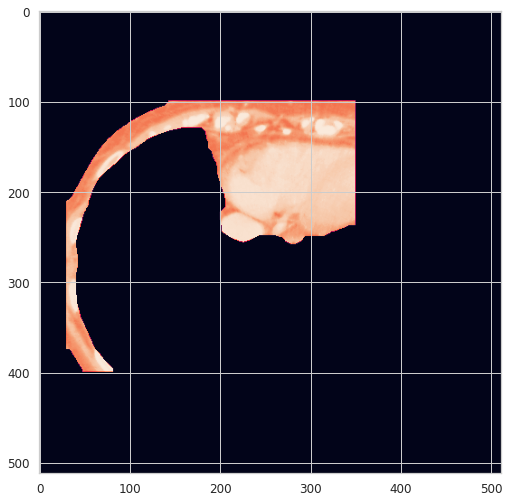

In [24]:
print(final.shape)
final = color.gray2rgb(final)
print(final.shape)
plt.imshow(final[:,:,2] )

In [25]:
data_path = "/content/drive/My Drive/3Dircadb1.1/MASKS_DICOM/liver"
patient = load_scan(data_path)
imgs = get_pixels_hu(patient)
output_path = working_path = "/content/drive/My Drive/3Dircadb1.1/PATIENT_DICOMOUTPUT"
np.save(output_path + "fullimages_%d.npy" % (0), imgs)
file_used=output_path+"fullimages_%d.npy" % (0)
livers_to_process = np.load(file_used).astype(np.float64) 


print ("Shape before resampling\t", livers_to_process.shape)
# livers_after_resamp, spacing = resample(livers_to_process, patient, [1,1,1])
# print ("Shape after resampling\t", livers_after_resamp.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Shape before resampling	 (129, 512, 512)


In [0]:
true = []
for slice in range(len(livers_to_process)):
    org =np.uint8(cv2.normalize(livers_to_process[slice], None, 0, 255, cv2.NORM_MINMAX))
    ret3,org = cv2.threshold(org,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    org  = np.float64(org)

    true.append(org)

# print(true.dtype)
# print(predicted.dtype)
# print(predicted.shape)
#print(len(true))
#plt.imshow(true[100], cmap='gray')
# plt.imshow(predicted[10], cmap='gray')

# print(true[5].shape)
# print(predicted[10].dtype)

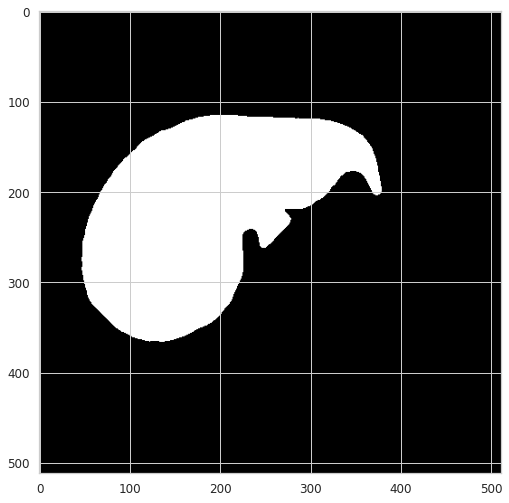

In [27]:
 plt.imshow(true[100], cmap='gray')


In [0]:
# #mean union intersection (mui)
# def score(predicted,true):
#   predict = predicted/255
#   y_train = true/255
#   m = tf.keras.metrics.MeanIoU(num_classes=2)
#   m.update_state(predict, y_train)
#   return m.result().numpy()

# sol = 0
# for slice in range(len(livers_to_process)):
#     sol += (score(predicted[slice],true[slice]))
# print(sol/len(livers_to_process) * 100)

In [0]:
########### segemented livers in predicted list ###############

In [0]:
#Function Definition¶


def change_color_fuzzycmeans(cluster_membership, clusters):
    img = []
    for pix in cluster_membership.T:
        img.append(clusters[np.argmax(pix)])
    return img

# def readimage():
#     folder = 'image-cancer/'
#     list_images = os.listdir(folder)
#     list_img = []
#     for i in list_images:
#         path = folder+i
#         print(path)
#         img = cv2.imread(path)
#         rgb_img = img.reshape((img.shape[0] * img.shape[1], 3))
#         list_img.append(rgb_img)
        
#     return list_img

def bwarea(img):
    row = img.shape[0]
    col = img.shape[1]
    total = 0.0
    for r in range(row-1):
        for c in range(col-1):
            sub_total = img[r:r+2, c:c+2].mean()
            if sub_total == 255:
                total += 1
            elif sub_total == (255.0/3.0):
                total += (7.0/8.0)
            elif sub_total == (255.0/4.0):
                total += 0.25
            elif sub_total == 0:
                total += 0
            else:
                r1c1 = img[r,c]
                r1c2 = img[r,c+1]
                r2c1 = img[r+1,c]
                r2c2 = img[r+1,c+1]
                
                if (((r1c1 == r2c2) & (r1c2 == r2c1)) & (r1c1 != r2c1)):
                    total += 0.75
                else:
                    total += 0.5
    return total
            
def imclearborder(imgBW):

    # Given a black and white image, first find all of its contours
    radius = 2
    imgBWcopy = imgBW.copy()
    contours = cv2.findContours(imgBWcopy.copy(), mode =cv2.RETR_LIST , 
        method = cv2.CHAIN_APPROX_SIMPLE)[0]
    print(imgBW.shape)
    # Get dimensions of image
    imgRows = imgBW.shape[0]
    imgCols = imgBW.shape[0]    

    contourList = [] # ID list of contours that touch the border

    # For each contour...
    for idx in np.arange(len(contours)):
        # Get the i'th contour
        cnt = contours[idx]

        # Look at each point in the contour
        for pt in cnt:
            rowCnt = pt[0][1]
            colCnt = pt[0][0]

            # If this is within the radius of the border
            # this contour goes bye bye!
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows-1-radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols-1-radius and colCnt < imgCols)

            if check1 or check2:
                contourList.append(idx)
                break

    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy

#### bwareaopen definition
def bwareaopen(imgBW, areaPixels):
    # Given a black and white image, first find all of its contours
    imgBWcopy = imgBW.copy()
    contours = cv2.findContours(imgBWcopy.copy(), mode =cv2.RETR_LIST , 
        method = cv2.CHAIN_APPROX_SIMPLE)[0]

    # For each contour, determine its total occupying area
    for idx in np.arange(len(contours)):
        area = cv2.contourArea(contours[idx])
        if (area >= 0 and area <= areaPixels):
            cv2.drawContours(imgBWcopy, contours, idx, (0,0,0), -1)

    return imgBWcopy      

def imfill(im_th):
    
    im_floodfill = im_th.copy()
    # Mask used to flood filling.
    
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv
    
    return im_out


20
(20, 512, 512)


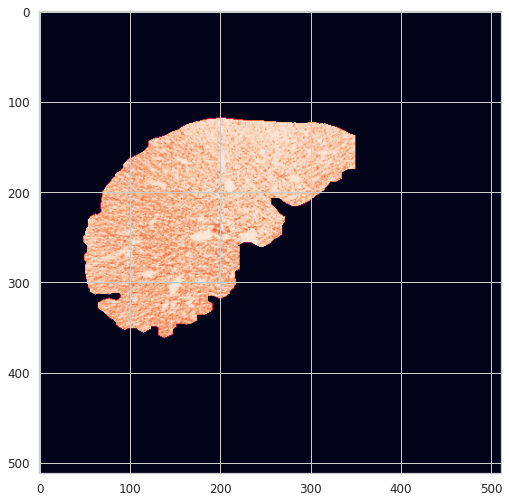

In [41]:
list_img = predicted
npre = np.array(predicted[80:100])
#Voxel intensities in the shape: 1 x N voxels (all the secret for clustering images...)
IB = npre.reshape((1,-1))
n_data = len(npre)

print(n_data)
plt.imshow(list_img[100])
print(npre.shape)


In [0]:
clusters = [2,3,6]

# looping every images
for index,img in enumerate(list_img):
    img = np.reshape(img, (512,512)).astype(np.uint8)
    shape = np.shape(img)
    
    
    # initialize graph
    plt.figure(figsize=(20,20))
    plt.subplot(1,4,1)
    plt.imshow(img)
    # looping every cluster     
    print('Image '+str(index+1))
    for i,cluster in enumerate(clusters):
            
        # Fuzzy C Means
        new_time = time()
        
        # error = 0.005
        # maximum iteration = 1000
        # cluster = 2,3,6,8
        
        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        img.T, cluster, 2, error=0.005, maxiter=1000, init=None,seed=42)

        new_img = change_color_fuzzycmeans(u,cntr)
        print(np.shape(new_img))
        plt.imshow(new_img)
    #     fuzzy_img = np.reshape(new_img,shape).astype(np.uint8)
    #     print(np.shape(fuzzy_img))
    #     ret, seg_img = cv2.threshold(fuzzy_img,np.max(fuzzy_img)-1,255,cv2.THRESH_BINARY)
    #     print(np.shape(seg_img))
    #     print('Fuzzy time for cluster',cluster)
    #     print(time() - new_time,'seconds')
    #     seg_img_1d = seg_img
    #     print(np.shape(seg_img_1d))
        
    #     bwfim1 = bwareaopen(seg_img_1d, 100)
    #     print(np.shape(bwfim1))
    #     bwfim2 = imclearborder(bwfim1)
    #     print(np.shape(bwfim2))
    #     bwfim3 = imfill(bwfim2)
        
    #     print('Bwarea : '+str(bwarea(bwfim3)))
    #     print()

    #     plt.subplot(1,4,i+2)
    #     plt.imshow(bwfim3)
    #     name = 'Cluster'+str(cluster)
    #     plt.title(name)

    # name = 'segmented'+str(index)+'.png'
    # plt.savefig(name)
    # print()

In [0]:
import numpy as np #v1.17.2
from scipy.spatial.distance import cdist #very important for the FCM. Scipy version: v1.3.1


def _distance(data, centers):
    """
    Euclidean distance from each point to each cluster center.
    Parameters
    ----------
    data : 2d array (N x Q)
        Data to be analyzed. There are N data points.
    centers : 2d array (C x Q)
        Cluster centers. There are C clusters, with Q features.
    Returns
    -------
    dist : 2d array (C x N)
        Euclidean distance from each point, to each cluster center.
    See Also
    --------
    scipy.spatial.distance.cdist
    """
    return cdist(data, centers).T
    
    
def _cmeans0(data, u_old, c, m):
    """
    Single step in generic fuzzy c-means clustering algorithm.
    Modified from Ross, Fuzzy Logic w/Engineering Applications (2010),
    pages 352-353, equations 10.28 - 10.35.
    """
    # Normalizing, then eliminating any potential zero values.
    u_old /= np.ones((c, 1)).dot(np.atleast_2d(u_old.sum(axis=0)))
    u_old = np.fmax(u_old, np.finfo(np.float64).eps)

    um = u_old ** m

    # Calculate cluster centers
    data = data.T
    cntr = um.dot(data) / (np.ones((data.shape[1],1)).dot(np.atleast_2d(um.sum(axis=1))).T)

    d = _distance(data, cntr)
    d = np.fmax(d, np.finfo(np.float64).eps)

    jm = (um * d ** 2).sum()

    u = d ** (- 2. / (m - 1))
    u /= np.ones((c, 1)).dot(np.atleast_2d(u.sum(axis=0)))

    return cntr, u, jm, d

def _fp_coeff(u):
    """
    Fuzzy partition coefficient "fpc" relative to fuzzy c-partitioned
    matrix "u". Measures 'fuzziness' in partitioned clustering.
    Parameters
    ----------
    u : 2d array (C, N)
        Fuzzy c-partitioned matrix; N = number of data points and C = number
        of clusters.
    Returns
    -------
    fpc : float
        Fuzzy partition coefficient.
    """
    n = u.shape[1]

    return np.trace(u.dot(u.T)) / float(n)
    
#Using the functions above
def FCM(data, c, m, error, maxiter, init=None, seed=None):
    """
    Fuzzy c-means clustering algorithm [1].
    Parameters
    *************************************************
    data : 2d array, size (S, N)
        Data for clustered.  N is the number of data sets; S is the number
        of features within each sample vector.
    c : int
        Desired number of clusters or classes.
    m : float
        Array exponentiation applied to the membership function u_old at each
        iteration, where U_new = u_old ** m.
    error : float
        Stopping criterion; stop early if the norm of (u[p] - u[p-1]) < error.
    maxiter : int
        Maximum number of iterations allowed.
    init : 2d array, size (S, N)
        Initial fuzzy c-partitioned matrix. If none provided, algorithm is
        randomly initialized.
    seed : int
        If provided, sets random seed of init. No effect if init is
        provided. Mainly for debug/testing purposes.
    Returns
    *************************************************
    cntr : 2d array, size (S, c)
        Cluster centers.  Data for each center along each feature provided
        for every cluster (of the `c` requested clusters).
    u : 2d array, (S, N)
        Final fuzzy c-partitioned matrix.
    u0 : 2d array, (S, N)
        Initial guess at fuzzy c-partitioned matrix (either provided init or
        random guess used if init was not provided).
    d : 2d array, (S, N)
        Final Euclidian distance matrix.
    jm : 1d array, length P
        Objective function history.
    p : int
        Number of iterations run.
    fpc : float
        Final fuzzy partition coefficient.
    Notes
    -----
    Source of inspiration [1].
    
    ----------
    [1] Ross, Timothy J. Fuzzy Logic With Engineering Applications, 3rd ed.
           Wiley. 2010. ISBN 978-0-470-74376-8 pp 352-353, eq 10.28 - 10.35.
    """
    # Setup u0
    if init is None:
        if seed is not None:
            np.random.seed(seed=seed)
        n = data.shape[1]
        u0 = np.random.rand(c, n)
        u0 /= np.ones(
            (c, 1)).dot(np.atleast_2d(u0.sum(axis=0))).astype(np.float64)
        init = u0.copy()
    u0 = init
    u = np.fmax(u0, np.finfo(np.float64).eps)

    # Initialize loop parameters
    jm = np.zeros(0)
    p = 0

    # Main cmeans loop
    while p < maxiter - 1:
        u2 = u.copy()
        [cntr, u, Jjm, d] = _cmeans0(data, u2, c, m)
        jm = np.hstack((jm, Jjm))
        p += 1

        # Stopping rule
        if np.linalg.norm(u - u2) < error:
            break

    # Final calculations
    error = np.linalg.norm(u - u2)
    fpc = _fp_coeff(u)

    return cntr, u, u0, d, jm, p, fpc

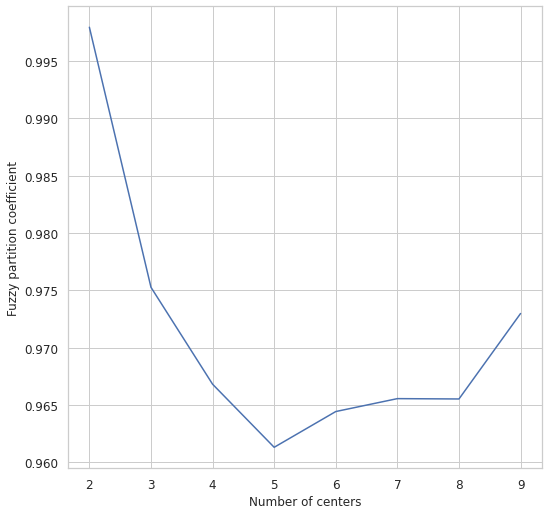

In [43]:
fuzziness_degree = 2
error = 0.000001
maxiter = 1000


fpcs = []

for n_clusters in range(2,10):
    cntr, u, u0, d, jm, p, fpc = FCM(IB,
                                     c=n_clusters,
                                     m=fuzziness_degree,
                                     error=error,
                                     maxiter=maxiter,
                                     init=None,
                                     seed=123456789)

    # Store fpc values for later
    fpcs.append(fpc)

fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:10], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")
plt.grid(True)

In [0]:
#N clusters
n_clusters = 6 #(n clusters + 1 background to be removed)
fuzziness_degree = 2
error = 0.000001
maxiter = 1000

In [0]:
cntr, uB, u0, d, jm, p, fpc = FCM(   IB,
            c=n_clusters,
            m=fuzziness_degree,
            error=error,
            maxiter=maxiter,
            init=None,
            seed=123456789)

In [0]:
#Getting Clusterd Image
img_clusteredB = np.argmax(uB, axis=0).astype(float)

img_clB = img_clusteredB.reshape(npre.shape)

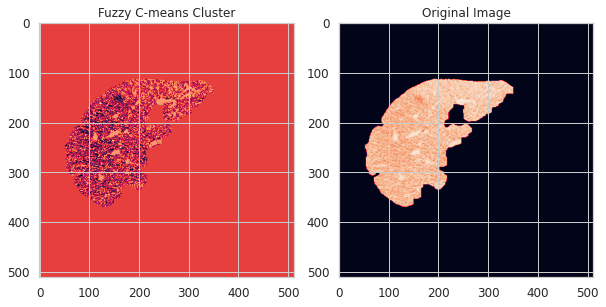

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2)

zz = 3 #image slice

axes[0].set_title("Fuzzy C-means Cluster")
axes[0].imshow(img_clB[zz,:,:])
axes[1].set_title("Original Image")
axes[1].imshow(npre[zz,:,:])
fig.tight_layout()
plt.show()